# Classifying Fashion-MNIST

___

In [1]:
import warnings, logging, os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

tfds.disable_progress_bar()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.__version__, tf.keras.__version__, tf.test.is_gpu_available()

('2.8.0', '2.8.0', False)

___

## LOAD THE FASHION DATA SET

This particular dataset has 2 splits, namely a `train` and a `test` slipt. We also see that the `train` split has 60,000 examples, and that the `test` split has 10,000 examples. 

Now, let's load the `fashion_mnist` dataset and inspect the returned values.

In [3]:
dataset, dataset_info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)

print('\nThe keys of dataset are:', list(dataset.keys()))

training_set, test_set = dataset['train'], dataset['test']


The keys of dataset are: ['train', 'test']


In [4]:
dataset_info.features['image']

Image(shape=(28, 28, 1), dtype=tf.uint8)

In [5]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=10)

In [6]:
dataset_info.splits['train']

<SplitInfo num_examples=60000, num_shards=1>

In [7]:
print('There are {:,} classes in our dataset'.format(dataset_info.features['label'].num_classes))
print('The images in our dataset have shape:', dataset_info.features['image'].shape)

print('\nThere are {:,} images in the test set'.format(dataset_info.splits['test'].num_examples))
print('There are {:,} images in the training set'.format(dataset_info.splits['train'].num_examples))

There are 10 classes in our dataset
The images in our dataset have shape: (28, 28, 1)

There are 10,000 images in the test set
There are 60,000 images in the training set


___

The images in this dataset are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, we create them here to use later when plotting the images:

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
            'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

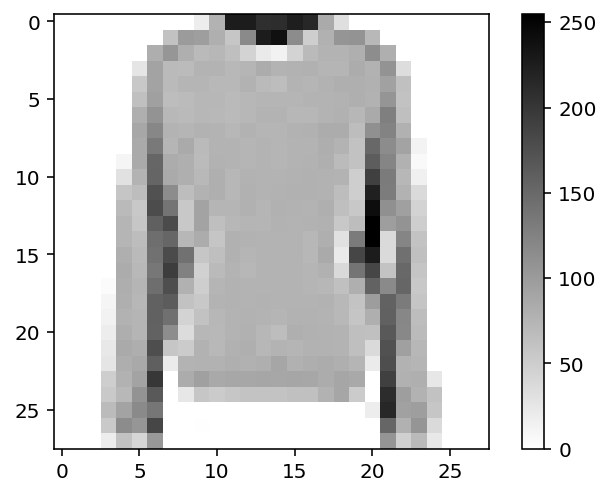

The label of this image is: 2
The class name of this image is: Pullover


In [9]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

___

## CREATE DATA PIPELINE and BUILD THE MODEL

In [10]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

train_batches = training_set.cache().shuffle(dataset_info.splits['train'].num_examples//4).batch(batch_size).map(normalize).prefetch(1)
test_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

In [11]:
clf_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

___

## TRAIN MODEL and EVALUATE METRICS

In [12]:
clf_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

EPOCHS = 5
history = clf_model.fit(train_batches, epochs = EPOCHS)

Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.4985 - accuracy: 0.8222
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3617 - accuracy: 0.8668
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3278 - accuracy: 0.8792
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3048 - accuracy: 0.8874
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.2883 - accuracy: 0.8923


In [13]:
loss, accuracy = clf_model.evaluate(test_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

157/157 [==============================] - 1s 4ms/step - loss: 0.3626 - accuracy: 0.8667

Loss on the TEST Set: 0.363
Accuracy on the TEST Set: 86.670%


___

## Check Predictions

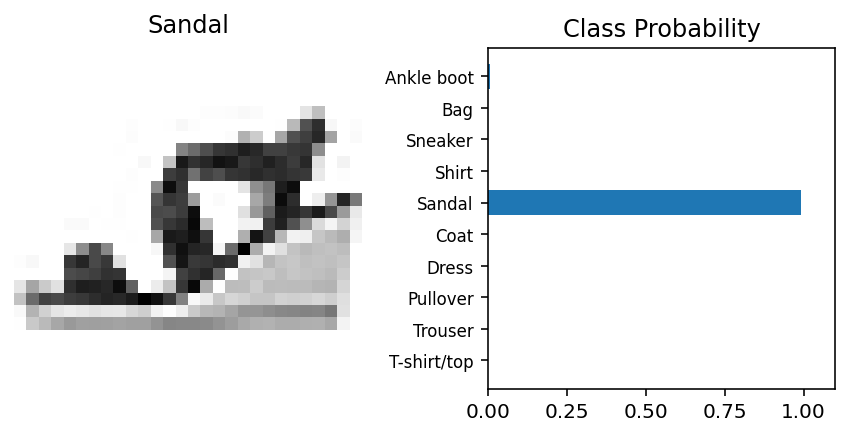

In [14]:
from random import randrange

rand_img = randrange(batch_size)

for image_batch, label_batch in test_batches.take(1):
    ps = clf_model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[rand_img]
    first_label = label_batch.numpy()[rand_img]

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax1.set_title(class_names[first_label])

ax2.barh(np.arange(10), ps[rand_img])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(class_names, size='small')
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()